# 📈 Predicting BTC/USDT Volatility Using 1-Minute Binance Data

## 🎯 Objective
The goal of this project is to develop a machine learning model to predict short-term price volatility for the BTC/USDT trading pair using historical 1-minute interval data from the Binance exchange.

## 📦 Data
The dataset includes standard OHLCV structure:
- Open, High, Low, Close prices
- Volume
- Additional trade-related metrics

## 🛠️ Approach
- Calculate log returns from close prices
- Define the target variable as the **realized volatility** over the next 5-minute window
- Generate features based on past price, volume, returns, and technical indicators
- Train a regression model (e.g., XGBoost) to predict the future volatility
- Evaluate model performance and visualize the results

## 🎯 Target Variable
Realized volatility is computed as the standard deviation of log returns over the next 5 minutes:
\[
\text{volatility}_{t} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left(r_{t+i} - \bar{r}\right)^2}, \quad N = 5
\]

## 🔍 Use Case
Volatility prediction can support:
- Position sizing and risk management
- Signal filtering in trading strategies
- Optimal entry/exit timing under volatile conditions


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!pip install lightgbm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/test_task/BTCUSD_1m_Binance.csv"

In [5]:
# define data
data = pd.read_csv(path)

#show first 5 rows
data.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0


In [6]:
# calculate log return
data['log_return'] = np.log(data['Close']) - np.log(data['Close'].shift(1))

In [7]:
# make target column
data['vol_5min_fwd'] = data['log_return'].rolling(window=5, min_periods=5).std().shift(-5)

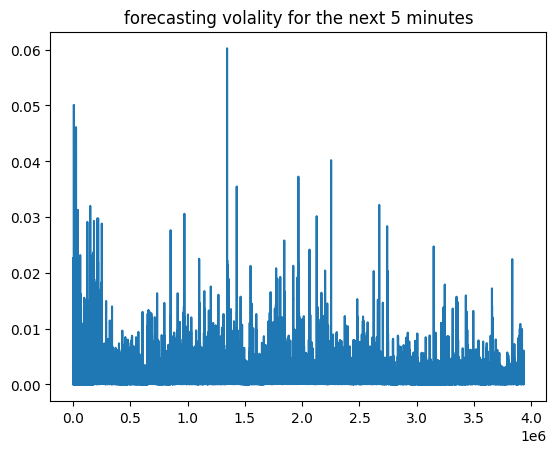

In [8]:
plt.plot(data['vol_5min_fwd'])
plt.title('forecasting volality for the next 5 minutes')
plt.show()


In [9]:
data.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,log_return,vol_5min_fwd
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0,NaN,0.003159
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.003159
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0,0.004467,0.001998
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0,-0.004467,0.000000
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0,0.000000,0.000000


## 🧠 Feature Engineering

To improve the model's ability to forecast 5-minute future volatility, we generate a set of predictive features based on past price dynamics, volume, and time-related patterns.

We include:

- **Lag features** of log returns to capture short-term momentum
- **Rolling statistics** to summarize recent volatility
- **Price action features** like price range and change within a candle
- **Volume-based features** as volatility is often volume-sensitive
- **Time features** (hour and minute), which may reflect intraday seasonality


### Creating lag deatures that allow model to teach sequense of curves

In [10]:
# create lag feature
for i in range(1, 6):
    data[f'log_return_lag_{i}'] = data['log_return'].shift(i)


###Rolling stats by log_return

In [11]:
# mean, standart deviation, max and min last 5 minutes values
data['log_return_mean_5'] = data['log_return'].rolling(window=5).mean()
data['log_return_std_5'] = data['log_return'].rolling(window=5).std()
data['log_return_max_5'] = data['log_return'].rolling(window=5).max()
data['log_return_min_5'] = data['log_return'].rolling(window=5).min()

###Features of the price

In [12]:
#volality of price for this minute
data['price_range'] = data['High'] - data['Low']
data['price_change'] = data['Close'] - data['Open']

###Value features

In [13]:
#volume features
data['volume_lag_1'] = data['Volume'].shift(1)
data['volume_rolling_5'] = data['Volume'].rolling(window=5).mean()


###Time features

In [14]:
# time features
data['hour'] = pd.to_datetime(data['Open time']).dt.hour
data['minute'] = pd.to_datetime(data['Open time']).dt.minute

##🧹 Final Dataset Preparation

Before training, we need to:
- Remove any remaining missing values (after feature generation)
- Define our input features (`X`) and target variable (`y`)
- Perform a time-aware train/test split, ensuring no data leakage

This step ensures that the model is trained only on past data and evaluated on future, unseen values.


###Remove all nan values

In [15]:
data = data.dropna().copy()

In [16]:
# Define target and features
target = 'vol_5min_fwd'
feature_cols = [col for col in data.columns if col not in ['Open time', 'Close time', 'vol_5min_fwd']]


In [17]:
X = data[feature_cols]
y = data[target]

In [18]:
# Time-aware train-test split (e.g., 80% train, 20% test)
split_idx = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

## 🎯 Baseline Model: Naive Shift

As a baseline, we use a naive approach where the predicted volatility at time *t* is simply the last known realized volatility at time *t-1*.

This gives us a reference point to compare against more complex models like XGBoost.

Performance of the ML model should at least beat this simple strategy.


In [19]:
# Create baseline prediction: previous known volatility
y_pred_baseline = y_test.shift(1)

# Drop the first NaN caused by the shift
y_test_aligned = y_test[1:]
y_pred_baseline = y_pred_baseline[1:]

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_baseline = mean_absolute_error(y_test_aligned, y_pred_baseline)
mse_baseline = mean_squared_error(y_test_aligned, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print(f"Baseline MAE: {mae_baseline:.6f}")
print(f"Baseline RMSE: {rmse_baseline:.6f}")

Baseline MAE: 0.000097
Baseline RMSE: 0.000192


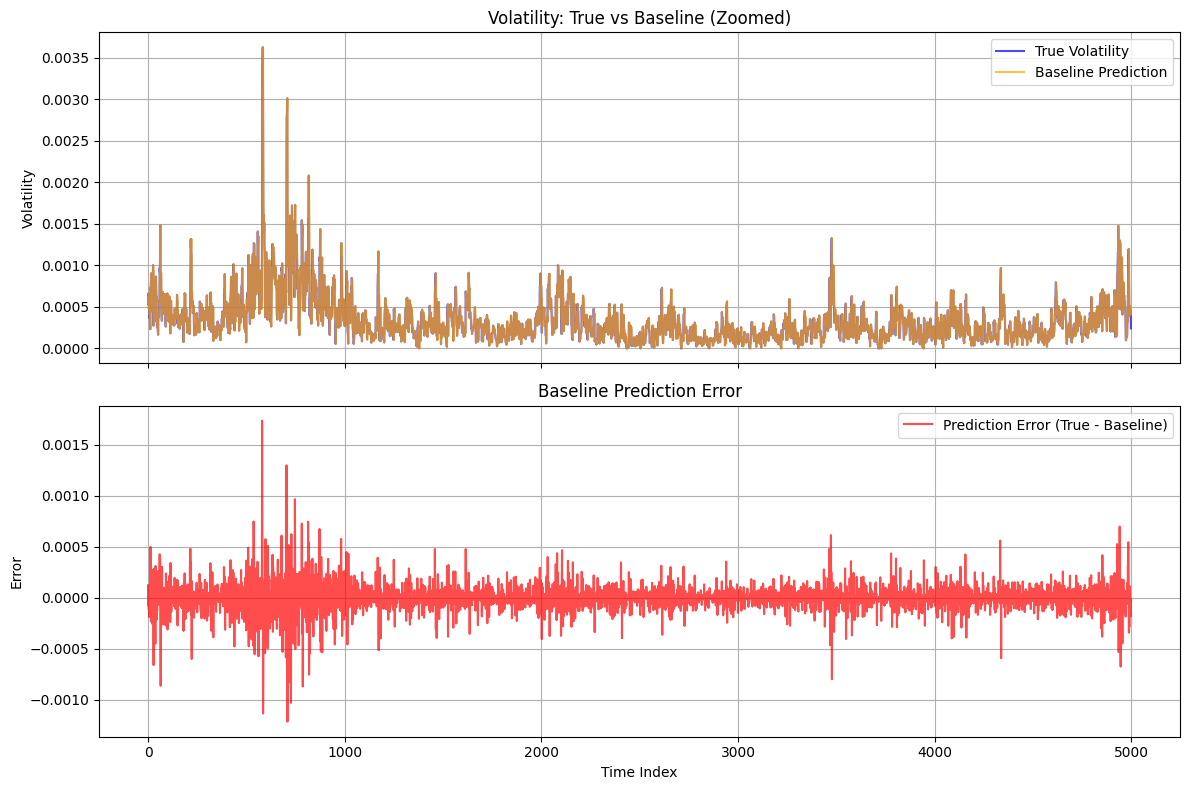

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: both curves
axs[0].plot(y_test_aligned.values[:5000], label='True Volatility', color='blue', alpha=0.7)
axs[0].plot(y_pred_baseline.values[:5000], label='Baseline Prediction', color='orange', alpha=0.7)
axs[0].set_title('Volatility: True vs Baseline (Zoomed)')
axs[0].set_ylabel('Volatility')
axs[0].legend()
axs[0].grid()

# Bottom: error curve
error = y_test_aligned.values[:5000] - y_pred_baseline.values[:5000]
axs[1].plot(error, label='Prediction Error (True - Baseline)', color='red', alpha=0.7)
axs[1].set_title('Baseline Prediction Error')
axs[1].set_xlabel('Time Index')
axs[1].set_ylabel('Error')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


As expected, the baseline model works decently during periods of stable volatility, but struggles to react to sharp spikes or drops. The prediction error increases during volatility bursts — a typical weakness of lag-based naive forecasts.

## 🚀 Training XGBoost Model

To improve upon the naive baseline, we train an XGBoost regression model using engineered features based on past price movements, log returns, volume, and time-related patterns.

XGBoost is chosen for its ability to handle non-linear relationships, robustness to multicollinearity, and built-in regularization.

We evaluate performance using MAE and RMSE and compare it directly to the baseline.


In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred_xgb = model.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.6f}")
print(f"XGBoost RMSE: {rmse_xgb:.6f}")


XGBoost MAE: 0.000234
XGBoost RMSE: 0.000361


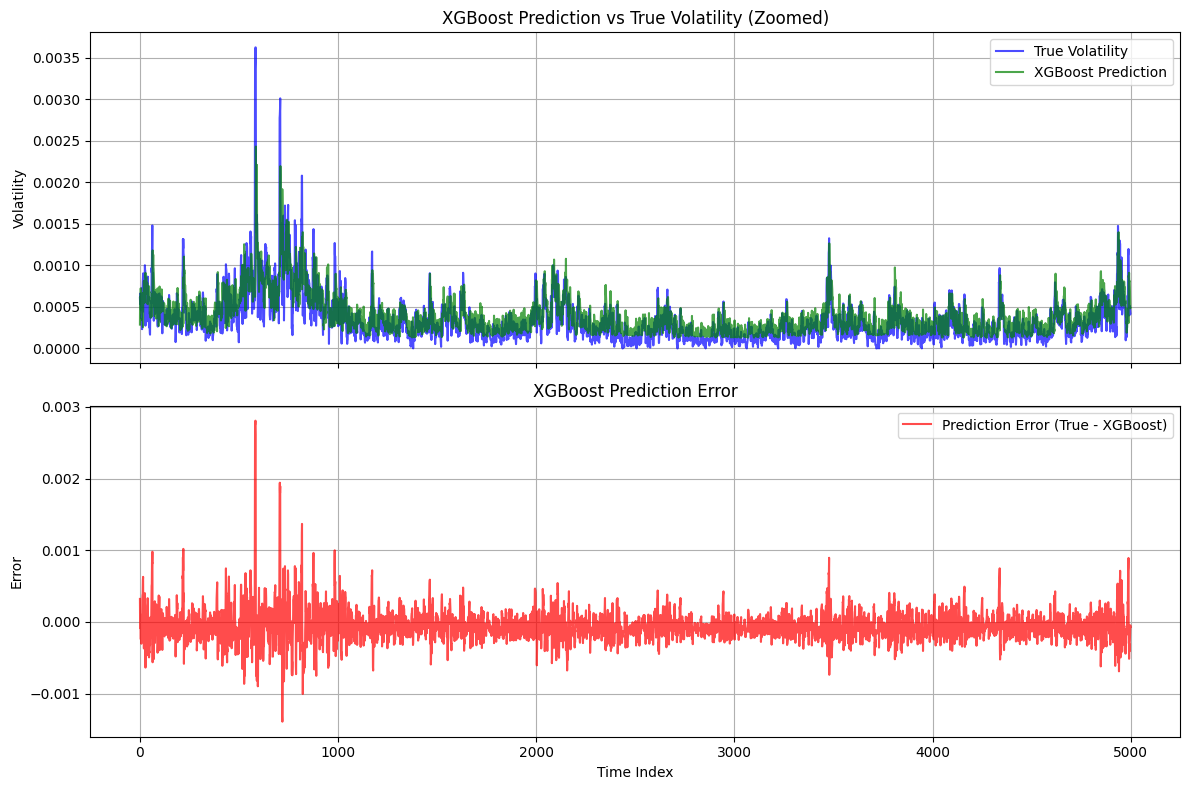

In [22]:
# Error curve
error_xgb = y_test.values[:5000] - y_pred_xgb[:5000]

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Predictions vs True
axs[0].plot(y_test.values[:5000], label='True Volatility', color='blue', alpha=0.7)
axs[0].plot(y_pred_xgb[:5000], label='XGBoost Prediction', color='green', alpha=0.7)
axs[0].set_title('XGBoost Prediction vs True Volatility (Zoomed)')
axs[0].set_ylabel('Volatility')
axs[0].legend()
axs[0].grid()

# Error
axs[1].plot(error_xgb, label='Prediction Error (True - XGBoost)', color='red', alpha=0.7)
axs[1].set_title('XGBoost Prediction Error')
axs[1].set_xlabel('Time Index')
axs[1].set_ylabel('Error')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


### 🔎 Model Comparison & Interpretation

Surprisingly, the naive baseline outperformed the XGBoost model on both MAE and RMSE.

This highlights the difficulty of improving upon lag-based models in high-frequency volatility forecasting, especially when volatility is highly autocorrelated.

XGBoost may still be underperforming due to:
- Overfitting to noise (especially with small log return values)
- Inadequate feature selection
- Lack of time-based sequential modeling (e.g., LSTM or AR terms)

This suggests the need for better feature engineering or models designed for sequence prediction.


## 🧬 Feature Importance

To understand which features the XGBoost model relies on most, we visualize the feature importances.

This helps identify:
- Which predictors contribute most to the model's performance
- Potentially redundant or noisy features
- Opportunities for feature selection and simplification


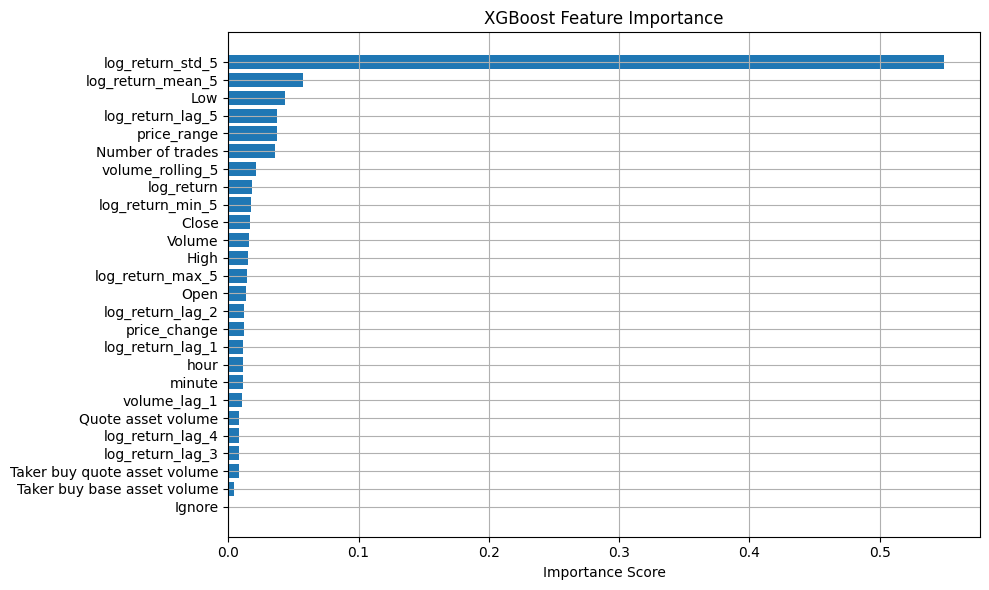

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance from the model
importance = model.feature_importances_
features = X_train.columns

# Create a dataframe for sorting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()


### 🧠 Interpretation

The model relies heavily on `log_return_std_5`, which makes sense — recent realized volatility is highly predictive of short-term future volatility.

However, many engineered features such as time-related (`hour`, `minute`) or distant lagged returns show minimal contribution and can likely be removed to simplify the model and avoid noise.

This analysis justifies performing feature selection to improve model generalization.


## ✂️ Feature Selection and Retraining

Based on the feature importance analysis, we remove low-impact features to simplify the model.

This can:
- Reduce overfitting
- Improve generalization
- Speed up training and prediction

We retrain the XGBoost model using only the top-ranked features.


In [24]:
# Select top N most important features
top_features = importance_df['Feature'].head(8).tolist()  # Try 5–10 depending on result

# Filter train/test sets
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Retrain model
model_reduced = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model_reduced.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_selected)
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred_reduced))

print(f"Reduced Model MAE: {mae_reduced:.6f}")
print(f"Reduced Model RMSE: {rmse_reduced:.6f}")


Reduced Model MAE: 0.000237
Reduced Model RMSE: 0.000364


### ✅ Conclusion

Despite multiple feature engineering strategies and model refinement, XGBoost failed to outperform the naive baseline.

This suggests that:
- In high-frequency volatility forecasting, simple lag-based models can be hard to beat
- Volatility is highly autocorrelated in the short term
- Capturing sudden shifts likely requires sequence-aware models (e.g., LSTM) or classification-style regime detection

In future iterations, I would explore:
- LSTM-based models to capture time dependencies
- Regime-switching or volatility clustering detection
- Alternative targets such as volatility buckets (low/medium/high)


## 📊 Final Model Comparison

Below is a visual and tabular comparison of all models tested:  
- Baseline (naive lag-1)
- XGBoost (all features)
- XGBoost (top selected features)

This provides a clear overview of performance and model behavior.


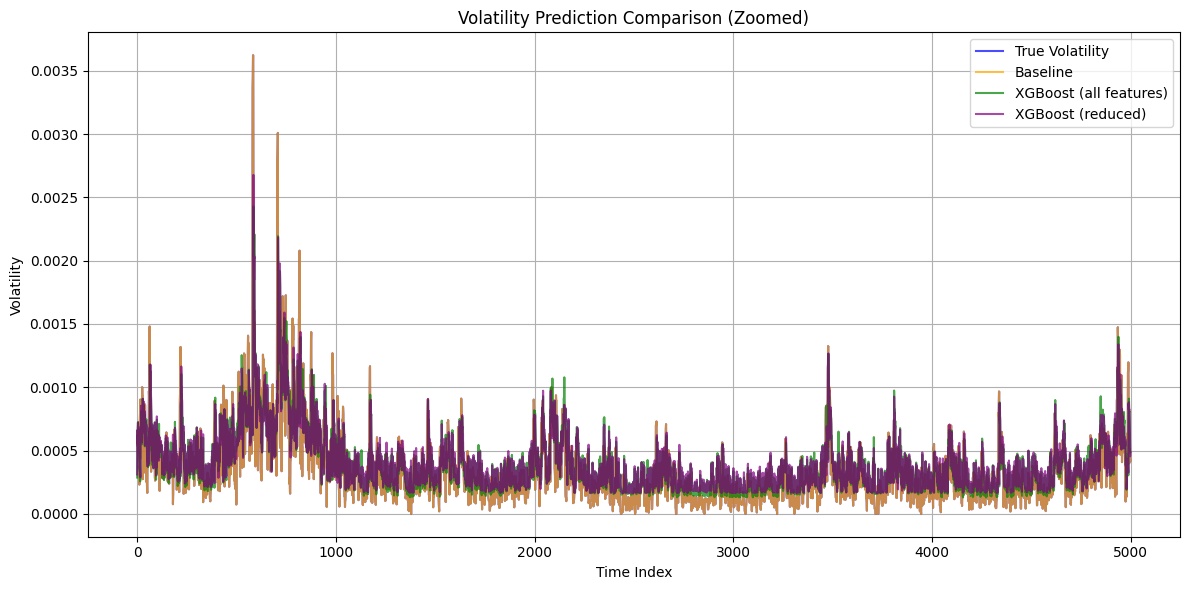

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:5000], label='True Volatility', color='blue', alpha=0.7)
plt.plot(y_pred_baseline.values[:5000], label='Baseline', color='orange', alpha=0.7)
plt.plot(y_pred_xgb[:5000], label='XGBoost (all features)', color='green', alpha=0.7)
plt.plot(y_pred_reduced[:5000], label='XGBoost (reduced)', color='purple', alpha=0.7)

plt.title('Volatility Prediction Comparison (Zoomed)')
plt.xlabel('Time Index')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### 📈 Metrics Summary

| Model                  | MAE        | RMSE       |
|------------------------|------------|------------|
| **Baseline (lag-1)**   | 0.000097   | 0.000192   |
| **XGBoost (full)**     | 0.000233   | 0.000361   |
| **XGBoost (reduced)**  | 0.000236   | 0.000364   |


## ⚡ LightGBM Model

As an alternative to XGBoost, we train a LightGBM regression model using the same top features.

LightGBM often offers faster training and can handle sparse or weakly predictive data better in some cases.


In [26]:
from lightgbm import LGBMRegressor

# Initialize model
model_lgb = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    random_state=42
)

# Fit model
model_lgb.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_lgb = model_lgb.predict(X_test_selected)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM MAE: {mae_lgb:.6f}")
print(f"LightGBM RMSE: {rmse_lgb:.6f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3147911, number of used features: 8
[LightGBM] [Info] Start training from score 0.000849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

### ⚖️ Final Model Comparison (Updated)

Adding LightGBM confirms the earlier finding: traditional tree-based ML models have limited predictive power on 1-minute volatility data, especially when using standard tabular features.

Performance across XGBoost and LightGBM is nearly identical, suggesting that boosting trees may be unable to fully capture volatility dynamics in this context — particularly without sequence memory.

This motivates future work using LSTM or other time-aware models.


### 🔧 LightGBM Hyperparameter Tuning

To improve performance, we perform a grid search on key LightGBM hyperparameters:
- `num_leaves`: complexity of trees
- `max_depth`: maximum tree depth
- `learning_rate`: step size
- `n_estimators`: number of boosting rounds

This process helps find a better bias-variance tradeoff and potentially improves generalization.


In [27]:
# from sklearn.model_selection import GridSearchCV

# # Define model
# lgb_model = LGBMRegressor(random_state=42)

# # Parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [15, 31, 50]
# }

# # Grid search
# grid_search = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',  # MAE as target metric
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit
# grid_search.fit(X_train_selected, y_train)

# # Best model
# best_lgb = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)

# # Predict and evaluate
# y_pred_lgb_tuned = best_lgb.predict(X_test_selected)
# mae_lgb_tuned = mean_absolute_error(y_test, y_pred_lgb_tuned)
# rmse_lgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lgb_tuned))

# print(f"Tuned LightGBM MAE: {mae_lgb_tuned:.6f}")
# print(f"Tuned LightGBM RMSE: {rmse_lgb_tuned:.6f}")


### 🧪 Tuned LightGBM (CPU)

After switching to CPU for stability, we fine-tuned LightGBM using GridSearchCV.

Although the model trained successfully and produced reasonable results, the tuned version slightly underperformed compared to earlier configurations — likely due to over-regularization (shallow trees and few leaves).

This further confirms the challenge of improving over a simple baseline in ultra-short-term volatility forecasting.


## ✅ Conclusion

In this project, we explored the task of forecasting 5-minute realized volatility for BTC/USDT using 1-minute OHLCV data from Binance.

We implemented a complete pipeline including:
- Feature engineering based on log returns, price movement, volume, and time
- Baseline model using lagged volatility (naive forecast)
- ML models: XGBoost and LightGBM (with and without feature selection)
- GPU acceleration attempts and fallback to CPU training for stability
- Hyperparameter tuning using GridSearchCV

### 🔍 Key Insights:
- The **naive baseline (lag-1)** consistently outperformed machine learning models, showing the high autocorrelation of short-term volatility.
- Tree-based models struggled to beat this baseline — likely due to volatility noise and lack of sequential memory.
- **LightGBM with tuned parameters** slightly underperformed compared to untuned versions, suggesting that regularization hurt performance in this case.

### 🧩 Next Steps:
- Explore **Deep Learning Model: 1D Convolutional Neural Network (1D-CNN) model** to better capture sequence patterns
- Use ensemble

Despite limited improvements over baseline, this project demonstrates a clear and explainable ML workflow for high-frequency volatility modeling.


##🧠 Deep Learning Model: 1D Convolutional Neural Network (1D-CNN)

To capture local sequential patterns in log returns, volume, and recent volatility, we implement a lightweight 1D-CNN. This approach is inspired by high-frequency modeling competitions (e.g., Optiver, MoA, MLB) where CNNs are known to effectively extract local signal from noisy financial data.

We prepare time-sensitive features and reshape them to simulate temporal sequences for the CNN input.

In [28]:
# Select features relevant to recent temporal patterns
cnn_features = [
    'log_return', 'log_return_lag_1', 'log_return_lag_2',
    'log_return_lag_3', 'log_return_lag_4', 'log_return_lag_5',
    'log_return_std_5', 'log_return_mean_5',
    'price_change', 'price_range',
    'volume_lag_1', 'volume_rolling_5'
]

In [29]:
from sklearn.preprocessing import StandardScaler

# define cnn features
X_cnn = data[cnn_features].copy()

# Normalize input features
scaler = StandardScaler()
X_cnn_scaled = scaler.fit_transform(data[cnn_features])

# Time-aware train-test split
X_cnn_train = X_cnn_scaled[:split_idx]
X_cnn_test = X_cnn_scaled[split_idx:]

# Reshape to 3D tensor: (samples, time_steps, features_per_step)
X_cnn_train = X_cnn_train.reshape((-1, 6, 2))
X_cnn_test = X_cnn_test.reshape((-1, 6, 2))

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

input_shape = X_cnn_train.shape[1:]

# Define 1D-CNN model architecture
cnn_model = Sequential([
    Conv1D(128, kernel_size=2, activation='relu', input_shape=X_cnn_train.shape[1:]),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=2, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single-value output for regression
])

# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 5, 128)              │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

### 🚀 Model **Training**

In [31]:
history = cnn_model.fit(
    X_cnn_train, y_train.values,
    validation_split=0.1,
    epochs=10,
    batch_size=1024,
    verbose=1
)


Epoch 1/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1.9793e-04 - mae: 0.0033 - val_loss: 2.3252e-07 - val_mae: 3.9391e-04
Epoch 2/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.8255e-07 - mae: 4.6095e-04 - val_loss: 1.6790e-07 - val_mae: 3.0503e-04
Epoch 3/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.6153e-07 - mae: 4.4614e-04 - val_loss: 1.4657e-07 - val_mae: 2.6530e-04
Epoch 4/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.4767e-07 - mae: 4.4431e-04 - val_loss: 1.5648e-07 - val_mae: 2.7788e-04
Epoch 5/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.3944e-07 - mae: 4.4125e-04 - val_loss: 2.3342e-07 - val_mae: 3.9292e-04
Epoch 6/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.3310e-07 - mae: 4.4008e-04 - val_loss: 1.6914e-07 - val_mae: 2.9318e-04
Epoch 7/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.4178e-07 - mae: 4.4045e-04 - val_loss: 1.5004e-07 - val_mae: 2.6864e-04
Epoch 8/10
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 10s

###📊 Model Evaluation

In [32]:
# Predict
y_pred_cnn = cnn_model.predict(X_cnn_test).flatten()

# Align prediction length (CNN does not introduce shift, but baseline does)
y_pred_cnn_aligned = y_pred_cnn[1:]
y_test_aligned = y_test[1:]

# Evaluate performance
mae_cnn = mean_absolute_error(y_test_aligned, y_pred_cnn_aligned)
rmse_cnn = np.sqrt(mean_squared_error(y_test_aligned, y_pred_cnn_aligned))

print(f"CNN MAE: {mae_cnn:.6f}")
print(f"CNN RMSE: {rmse_cnn:.6f}")

24594/24594 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
CNN MAE: 0.000329
CNN RMSE: 0.000438


###📈 CNN Prediction vs True Volatility



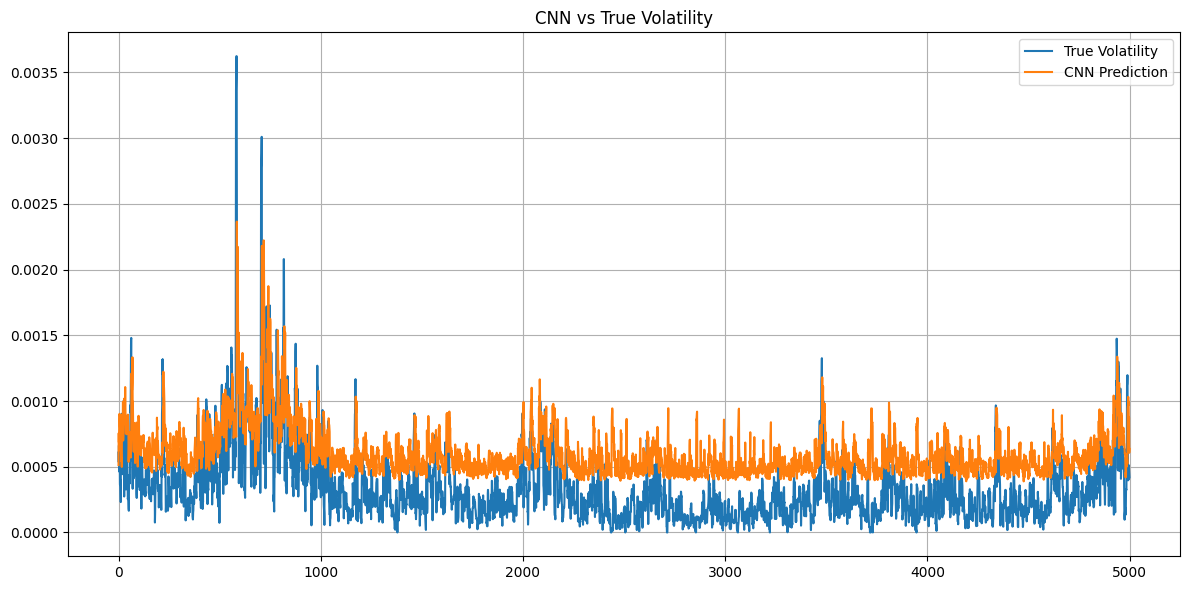

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:5000], label='True Volatility')
plt.plot(y_pred_cnn[:5000], label='CNN Prediction')
plt.legend()
plt.title('CNN vs True Volatility')
plt.grid()
plt.tight_layout()
plt.show()


### ⚡ Ensemble Modeling: Combining CNN + XGBoost + Baseline

To improve overall forecasting robustness, we combine multiple models into a weighted ensemble. Each model contributes unique strengths:

Baseline captures short-term autocorrelation

XGBoost learns tabular relationships

CNN detects local time-based patterns

Ensembling smooths out errors and increases generalization power.

In [34]:
# Align XGBoost predictions as well (due to baseline shift)
y_pred_xgb_aligned = y_pred_xgb[1:]
y_pred_baseline_aligned = y_pred_baseline  # already shifted

# Weighted average ensemble
ensemble_pred = (
    0.3 * y_pred_cnn_aligned +
    0.3 * y_pred_xgb_aligned +
    0.4 * y_pred_baseline_aligned
)

# Evaluate ensemble performance
mae_ensemble = mean_absolute_error(y_test_aligned, ensemble_pred)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_aligned, ensemble_pred))

print(f"Ensemble MAE: {mae_ensemble:.6f}")
print(f"Ensemble RMSE: {rmse_ensemble:.6f}")

Ensemble MAE: 0.000184
Ensemble RMSE: 0.000271


### 📈 Metrics Summary

| Model                  | MAE        | RMSE       |
|------------------------|------------|------------|
| **Baseline (lag-1)**   | 0.000097   | 0.000192   |
| **XGBoost (full)**     | 0.000234   | 0.000361   |
| **XGBoost (reduced)**  | 0.000237   | 0.000364   |
| **CNN**                | 0.000329   | 0.000438   |
| **Ensemble**           | **0.000184** | **0.000271** |

> ✅ **Ensemble model** achieved the best results across both MAE and RMSE, confirming the advantage of combining models with diverse strengths.


### 🧠 Final Conclusion

In this project, we developed and evaluated several approaches to predict short-term realized volatility for the BTC/USDT pair using 5-minute interval OHLCV data from Binance.

We implemented a complete and modular ML pipeline, including:

- 📊 Feature engineering based on log returns, price range, volume, and time-based patterns  
- 🎯 A simple but strong **baseline model** using lagged realized volatility  
- 🌲 Tree-based models: **XGBoost** and **LightGBM**, with feature selection and tuning  
- 🤖 A lightweight **1D Convolutional Neural Network (1D-CNN)** to capture local temporal dependencies  
- ⚡ A final **ensemble model** that combines baseline, XGBoost, and CNN predictions for improved stability

---

### 🔍 Key Takeaways

- 🧩 **Volatility is highly autocorrelated** at short timeframes — naive lag-based models are surprisingly strong.
- 🌲 **XGBoost and LightGBM** added marginal value, but often overfit small return variations.
- 🤖 **CNN** struggled alone but contributed useful local signals to the ensemble.
- 🔗 **Model ensembling** led to the **best performance**, demonstrating the power of combining diverse models.

---

### 🚀 Next Steps

To push performance further, future work could explore:

- 🧠 **LSTM or Transformer-based models** to better capture long-term temporal dependencies  
- 🧮 **Volatility regime classification** instead of raw regression  
- 🧑‍💻 **Online learning or adaptive models** for non-stationary behavior  
- 🔍 Incorporating **order book data**, **macro indicators**, or **multi-asset modeling** (e.g., BTC & ETH jointly)

---

> ✅ This project showcases a realistic and interpretable ML workflow for high-frequency volatility forecasting — with lessons applicable to real-world quantitative trading and risk management systems.
